#### Singleomic Results
##### First we use only one layer for the latent space analysis. Which layer? Let's see some results.
- Load the 3 layers and drop the samples that are not present on every dataset
- Use the data processing function from Models to get the data with variance filtered features and min max normalized, as well as the swap noisy data.

In [3]:
import Models
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
sns.set()

# Load Data
X_brca_methyl_data = pd.read_csv('./BRCA_methylation.txt', sep=',', index_col=0) # Dataset has Donor ID as first column
X_brca_mRNA_data = pd.read_csv('./BRCA_mRNA.txt', sep=',', index_col=0) # Dataset has Donor ID as first column
X_brca_CNA_data = pd.read_csv('./BRCA_CNA.txt', sep=',' ,index_col=0) # Dataset has Donor ID as first column
y_brca_data = pd.read_csv('./BRCA_Clinical.txt', sep=',', index_col=0, names=["Label"]) # Dataset has Donor ID on first column and Label on second column.

X_brca_methyl_filtered = X_brca_methyl_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01"], axis=1)
X_brca_mRNA_filtered = X_brca_mRNA_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=1)
X_brca_CNA_filtered = X_brca_CNA_data.drop(["TCGA-AR-A0U1-01"], axis=1)
y_brca_filtered = y_brca_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=0)


X_train_first_norm, X_train_second_norm, X_swapped_first_norm, X_swapped_second_norm, X_test_first_norm, X_test_second_norm, X_train_concat, X_swapped_concat, X_test_concat, y_train, y_test, y_train_oh, y_test_oh \
    = Models.prepare_datasets(X_brca_methyl_filtered.T,X_brca_mRNA_filtered.T, y_brca_filtered, test_size=0.2, swap_noise=0.15)



swapping: 20 rows.


In [18]:
X_train_first_norm.shape

(130, 5475)

In [45]:
import importlib
importlib.reload(Models)

<module 'Models' from 'C:\\Desarrollo\\Data Science\\Jupyter Notebooks\\Stage\\oss-stage-2019\\Multiomic Dataset\\Models.py'>

For the methylation layer, the processed datasets consists of 130 training samples of 3575 features, from the initial 165 samples of 14299 features. We can clearly see that this datasets suffers from the "curse of dimensionality", the samples to features ratio is extremely low (0.011 originally, 0.036 for training dataset) . We can visualize the first two components of the data obtained by applying PCA to obtain an overview of the its variance.

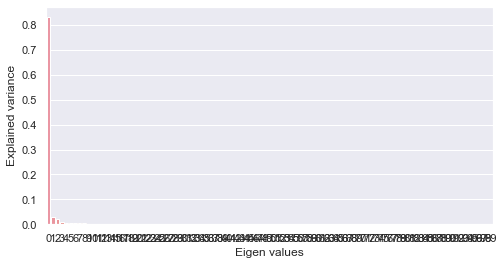

PCA on single-modal explained variance ratio: 0.9958273891677306


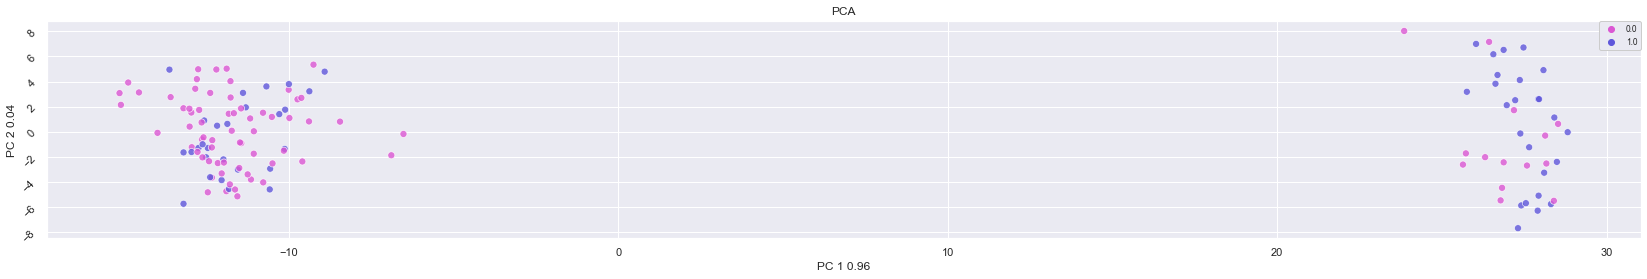

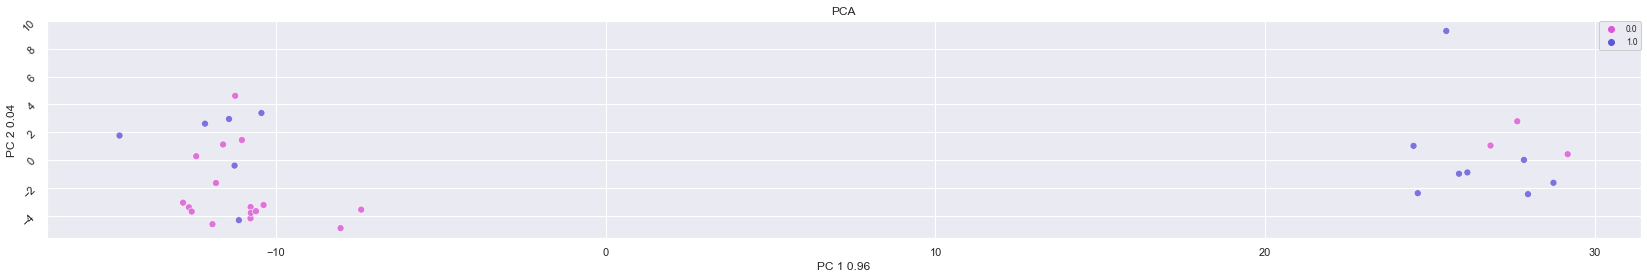

In [4]:
X_latent_pca, X_latent_pca_test = Models.perform_PCA(X_train_first_norm, y_train, X_test_first_norm, y_test, n_components=100)

Mainly, we notice 2 things: The first component explains more than 80% of the variance, about 30 times more than the second component. Thus the wide plot, where the axis are scaled to match the components ratio. Next, we see that the data tends to form two separated groups, with overlapped labels. This will be a problem for clustering algorithms, and hard for classification. Let's see first the results of these algorithms on the original data. It is useful to compute the ratio of each class on the test data, to identify the accuracy we will have if we decided to classify every sample the same way. 

Results for Original: 



C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

Best score for training data: 0.7 

Best C: 0.01 



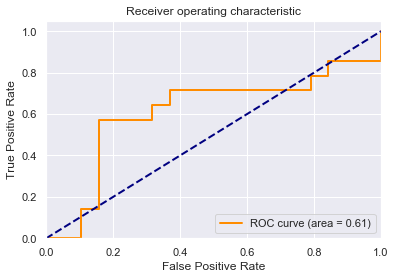

[[16  3]
 [ 7  7]]


              precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.70      0.50      0.58        14

    accuracy                           0.70        33
   macro avg       0.70      0.67      0.67        33
weighted avg       0.70      0.70      0.69        33

Training set score for Logistic Regression: 0.723077
Testing  set score for Logistic Regression: 0.696970
Best score for training data: 0.6923076923076923 

Best C: 0.5 

Best Gamma: 0.01 



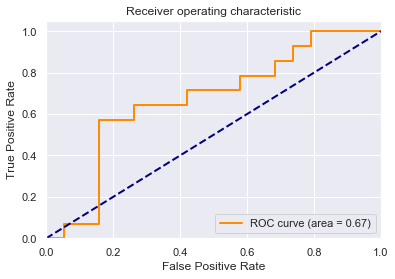

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for SVM: 0.723077
Testing  set score for SVM: 0.727273
Best score for training data: 0.7 

Best #estimators: 90 

Best max depth: 8 



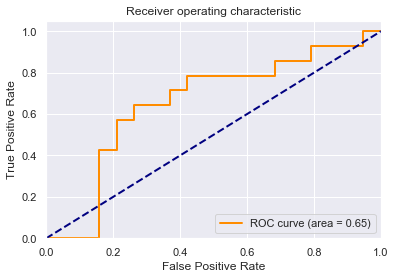

[[15  4]
 [ 8  6]]


              precision    recall  f1-score   support

           0       0.65      0.79      0.71        19
           1       0.60      0.43      0.50        14

    accuracy                           0.64        33
   macro avg       0.63      0.61      0.61        33
weighted avg       0.63      0.64      0.62        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.636364


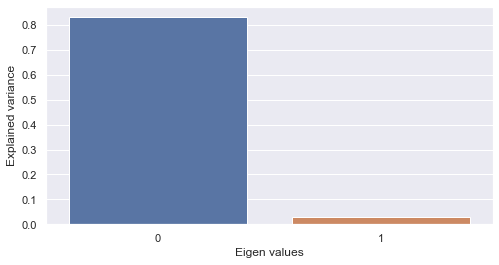

PCA on single-modal explained variance ratio: 0.8614081705283365


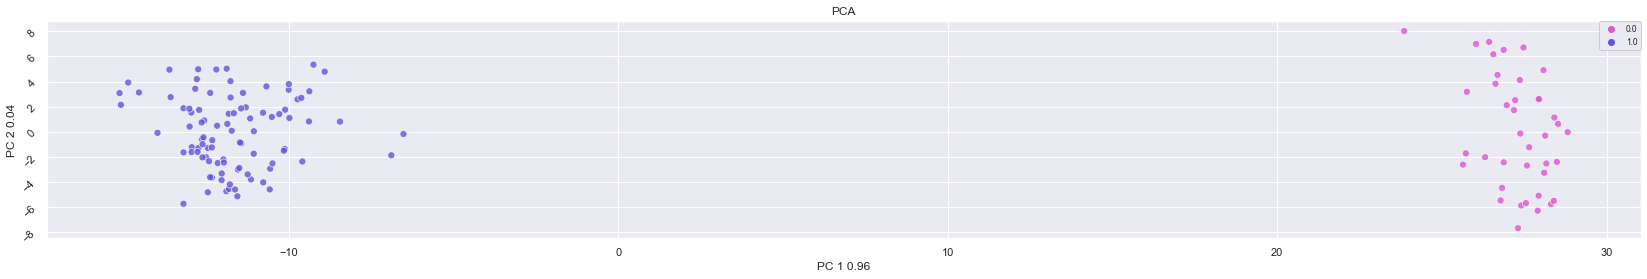

2 clusters -  silhoutte score: 0.7259081692369289 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.29333493179911957 - mutual information: 0.058444507339122986
4 clusters -  silhoutte score: 0.14448658616058727 - mutual information: 0.07022784171775798


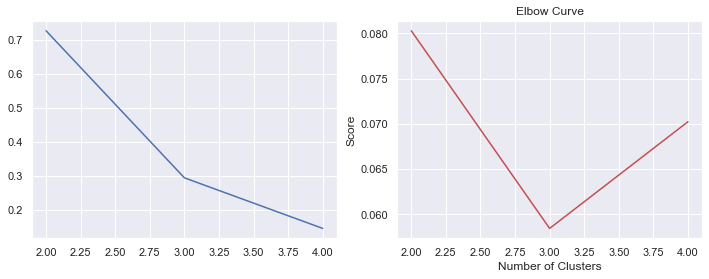

C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


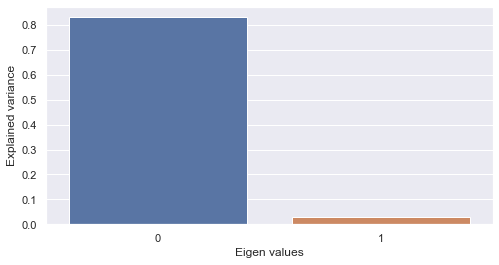

PCA on single-modal explained variance ratio: 0.8614081705283365


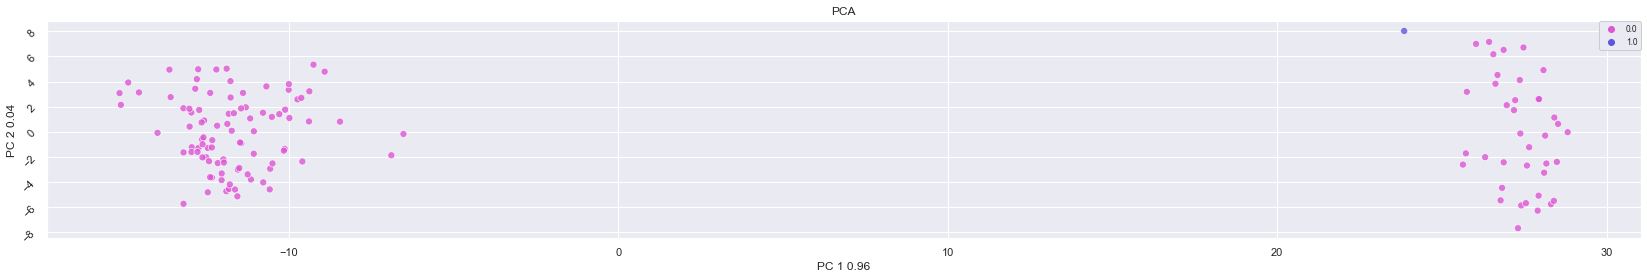

2 clusters -  silhoutte score: 0.24178664045242382 - mutual information: 0.010999010755058757


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


3 clusters -  silhoutte score: 0.23734315777988563 - mutual information: 0.028782411885727343
4 clusters -  silhoutte score: 0.21972241249523236 - mutual information: 0.04481137671716898


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


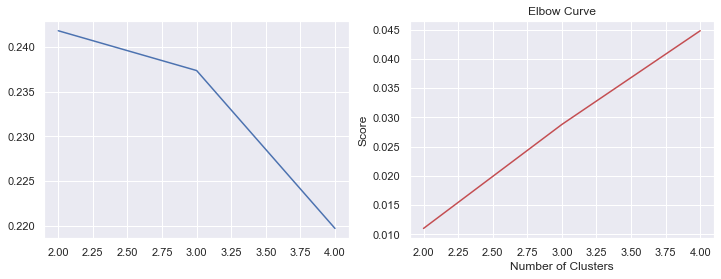

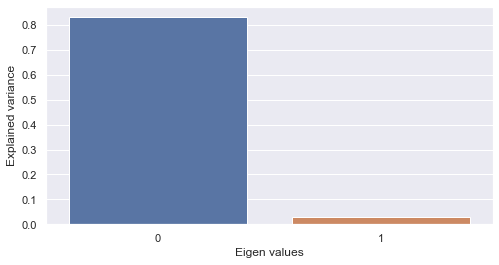

PCA on single-modal explained variance ratio: 0.8614081705283365


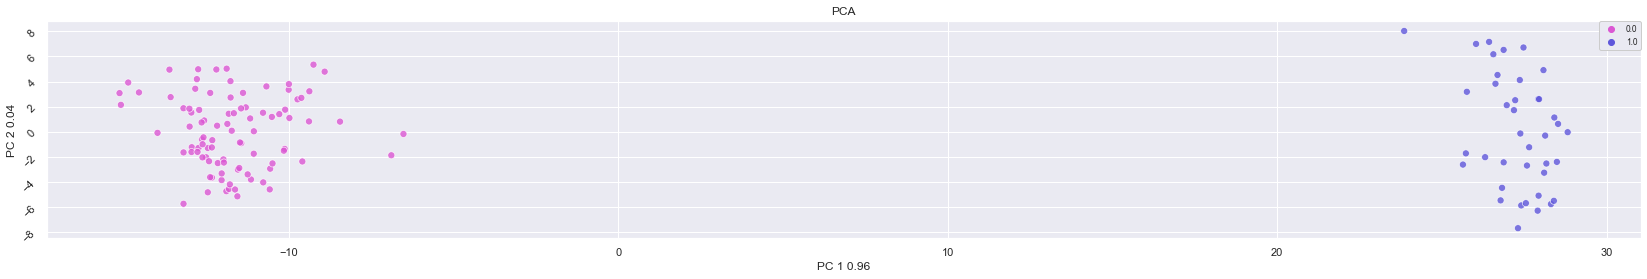

2 clusters -  silhoutte score: 0.7259081692369289 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.2777040311082488 - mutual information: 0.06555245117295233
4 clusters -  silhoutte score: 0.1180752846166754 - mutual information: 0.06188743712750047


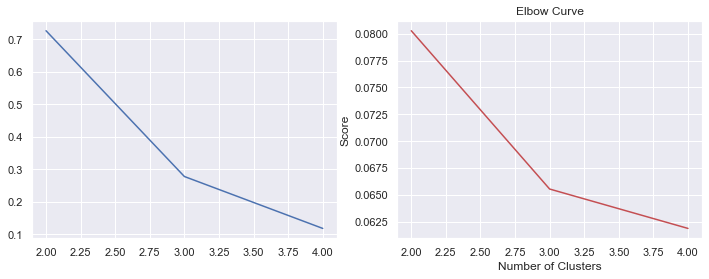

,LR accuracy,SVM accuracy,RF accuracy,LR ROC-AUC,SVM ROC-AUC,RF ROC-AUC,KMeans Silhouette,Spectral Silhouette,Hierarchical Silhouette,KMeans MI,Spectral MI,Hierarchical MI
original,0.69697,0.727273,0.636364,0.609023,0.669173,0.654135,0.725908,0.241787,0.725908,0.080276,0.010999,0.080276


No classifier: 0.5757575757575758


In [5]:
### CLASSIFICATION ###
classify = Models.classify_with_cv(X_train_first_norm, X_test_first_norm, np.ravel(y_train), np.ravel(y_test), model_type="Original")
### CLUSTERING ###
clustering = Models.cluster(X_train_first_norm,np.ravel(y_train), model_type="Original")

original_scores = pd.DataFrame([classify + clustering], index=["original"],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    
display(original_scores)
print(f"No classifier: {y_test.iloc[:,0].value_counts()[0]/len(y_test)}")

These results suggest that there is a significant improvement over a random classifier. For clustering, we confirmed our suspicion, the silhouette score values suggest tight and separated clusters (except for Spectral clustering), while the low mutual information indicate low correspondence between the ground thruth labels and the algorithm obtained ones. Let´s see the results when evaluating on the PCA latent space.

Results for PCA: 

Best score for training data: 0.7 

Best C: 0.01 



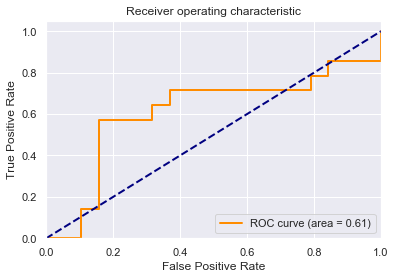

[[16  3]
 [ 7  7]]


              precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.70      0.50      0.58        14

    accuracy                           0.70        33
   macro avg       0.70      0.67      0.67        33
weighted avg       0.70      0.70      0.69        33

Training set score for Logistic Regression: 0.723077
Testing  set score for Logistic Regression: 0.696970
Best score for training data: 0.6923076923076923 

Best C: 0.5 

Best Gamma: 0.01 



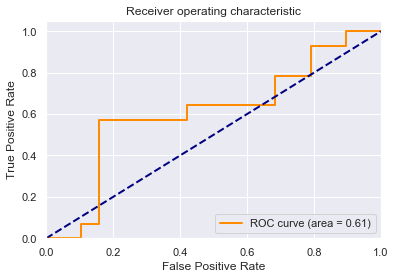

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for SVM: 0.723077
Testing  set score for SVM: 0.727273
Best score for training data: 0.6692307692307693 

Best #estimators: 80 

Best max depth: 8 



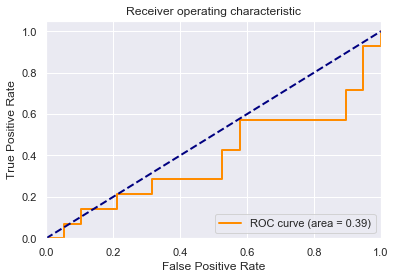

[[17  2]
 [12  2]]


              precision    recall  f1-score   support

           0       0.59      0.89      0.71        19
           1       0.50      0.14      0.22        14

    accuracy                           0.58        33
   macro avg       0.54      0.52      0.47        33
weighted avg       0.55      0.58      0.50        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.575758


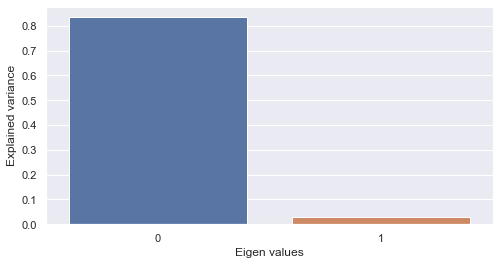

PCA on single-modal explained variance ratio: 0.8650175521364847


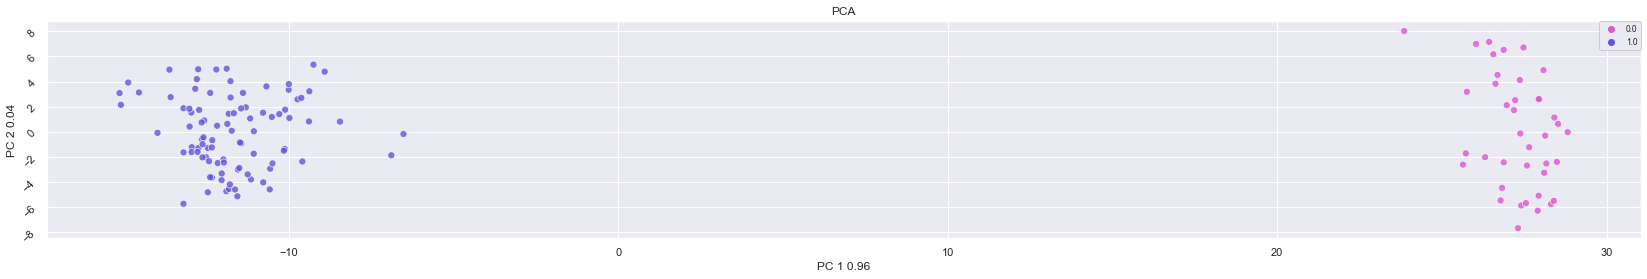

2 clusters -  silhoutte score: 0.7308098521426856 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.30167947047623744 - mutual information: 0.059017345839704506
4 clusters -  silhoutte score: 0.15276660748843054 - mutual information: 0.07073081903389851


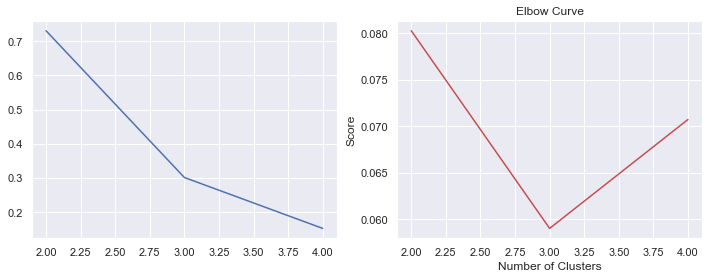

C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


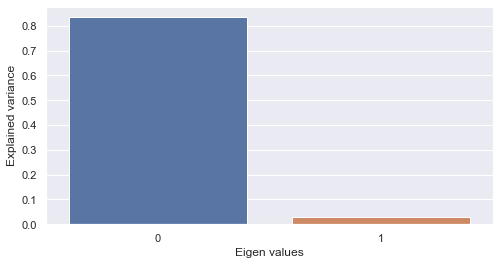

PCA on single-modal explained variance ratio: 0.8650175521364847


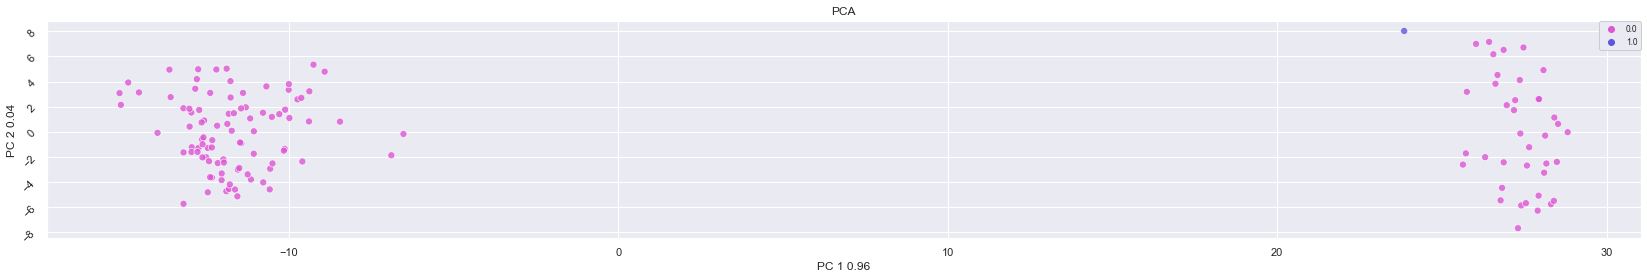

2 clusters -  silhoutte score: 0.24544949217268383 - mutual information: 0.010999010755058757


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


3 clusters -  silhoutte score: 0.24102395218724204 - mutual information: 0.028782411885727343
4 clusters -  silhoutte score: 0.24102395218724204 - mutual information: 0.028782411885727343


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\cluster\_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)


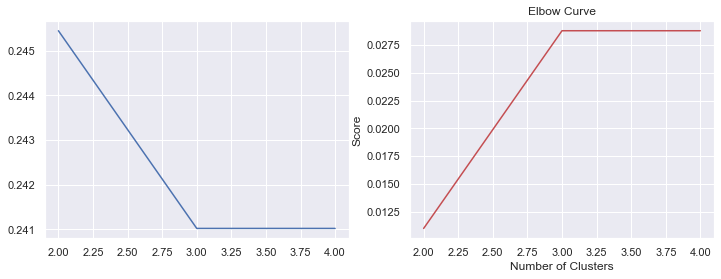

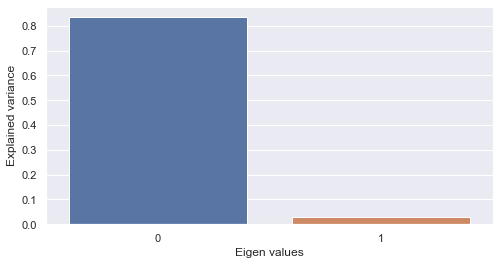

PCA on single-modal explained variance ratio: 0.8650175521364847


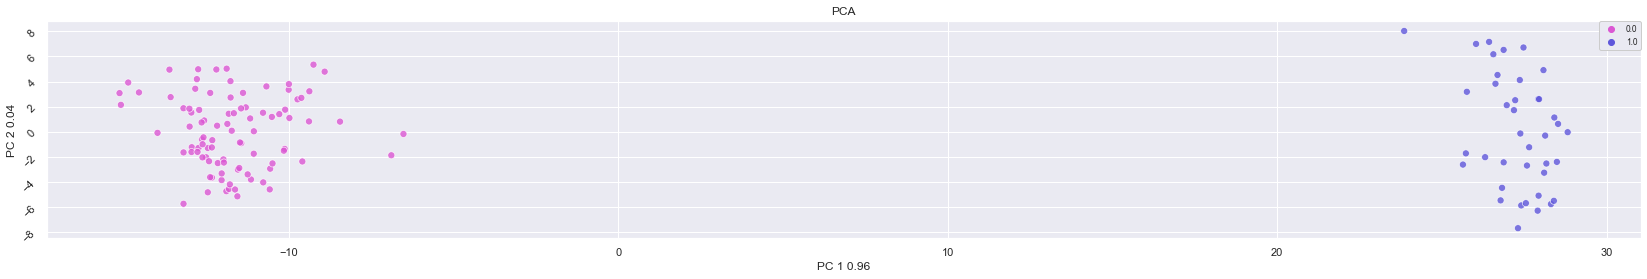

2 clusters -  silhoutte score: 0.7308098521426856 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.2791560756761572 - mutual information: 0.06391089692777463
4 clusters -  silhoutte score: 0.11962440547460891 - mutual information: 0.06038646952026674


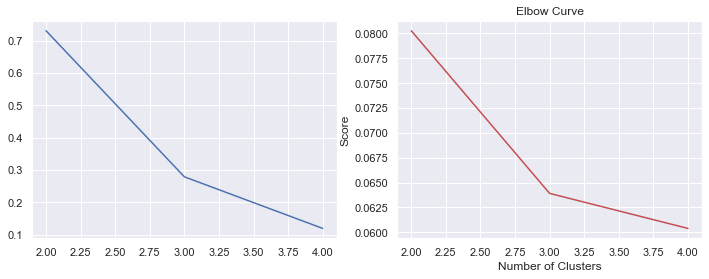

,LR accuracy,SVM accuracy,RF accuracy,LR ROC-AUC,SVM ROC-AUC,RF ROC-AUC,KMeans Silhouette,Spectral Silhouette,Hierarchical Silhouette,KMeans MI,Spectral MI,Hierarchical MI
original,0.69697,0.727273,0.636364,0.609023,0.669173,0.654135,0.725908,0.241787,0.725908,0.080276,0.010999,0.080276
PCA,0.69697,0.727273,0.575758,0.609023,0.609023,0.390977,0.730810,0.245449,0.730810,0.080276,0.010999,0.080276


No classifier: 0.5757575757575758


In [6]:
### CLASSIFICATION ###
classify = Models.classify_with_cv(X_latent_pca, X_latent_pca_test, np.ravel(y_train), np.ravel(y_test), model_type="PCA")
### CLUSTERING ###
clustering = Models.cluster(X_latent_pca,np.ravel(y_train), model_type="PCA")

pca_scores = pd.DataFrame([classify + clustering], index=['PCA'],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    
display(pd.concat([original_scores, pca_scores]))
print(f"No classifier: {y_test.iloc[:,0].value_counts()[0]/len(y_test)}")

We have similar performance for classification (except for random forest, that by viewing the accuracy on training data, we see that it is overfitting too much). For clustering we have the same problem, very low MI and even higher Silhouette score. Let´s see if we can improve this by nonlinearly transforming data with KPCA. First we compute the KPCA latent space. The best kernel function was obtained through grid search, giving best results for the rbf function with gamma=0.008.

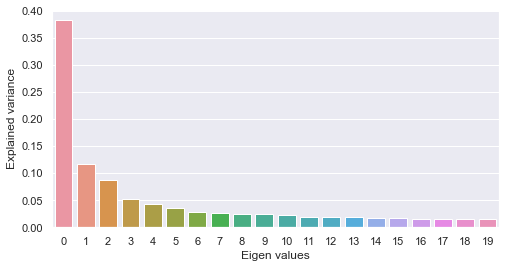

0.7184533234916387


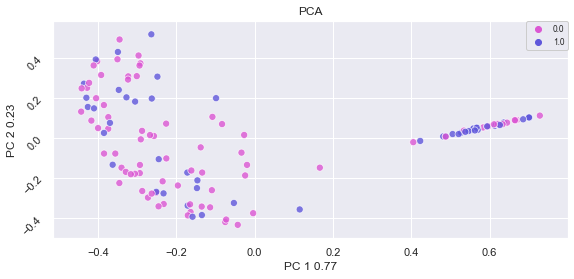

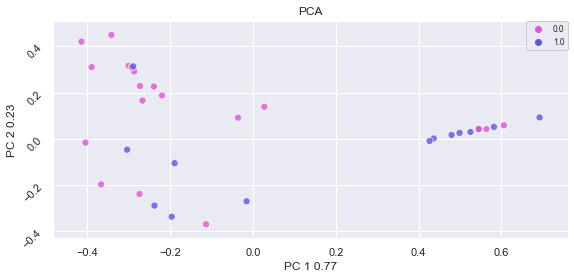

In [9]:
X_latent_kpca, X_latent_kpca_test = Models.perform_KPCA(X_train_first_norm, y_train, X_test_first_norm, y_test, variance_threshold=0)

This time, we have a similar setup, two highly overlapped groups, but we see that the right group was "flattened" into a manifold. Let's compare the results of the evaluation of KPCA latent space.

Results for KPCA: 

Best score for training data: 0.6923076923076923 

Best C: 0.5 



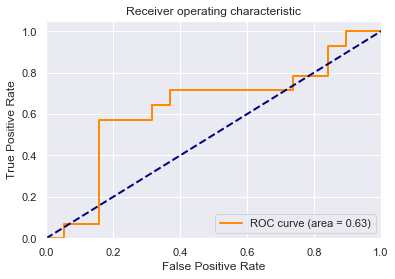

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for Logistic Regression: 0.715385
Testing  set score for Logistic Regression: 0.727273
Best score for training data: 0.6923076923076923 

Best C: 0.5 

Best Gamma: 0.5 



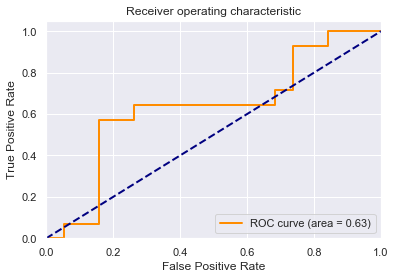

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for SVM: 0.707692
Testing  set score for SVM: 0.727273
Best score for training data: 0.6692307692307693 

Best #estimators: 100 

Best max depth: 8 



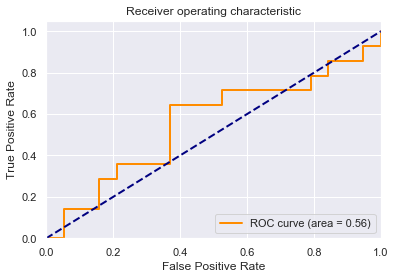

[[16  3]
 [10  4]]


              precision    recall  f1-score   support

           0       0.62      0.84      0.71        19
           1       0.57      0.29      0.38        14

    accuracy                           0.61        33
   macro avg       0.59      0.56      0.55        33
weighted avg       0.60      0.61      0.57        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.606061


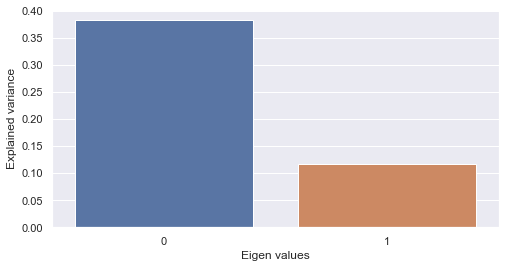

PCA on single-modal explained variance ratio: 0.4989728180660874


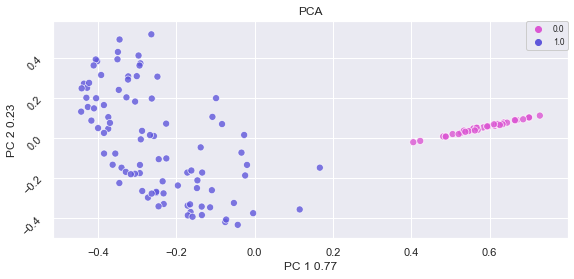

2 clusters -  silhoutte score: 0.37325199657341085 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.2400075560319417 - mutual information: 0.06753590720958419
4 clusters -  silhoutte score: 0.2434347940243112 - mutual information: 0.06960567279759827


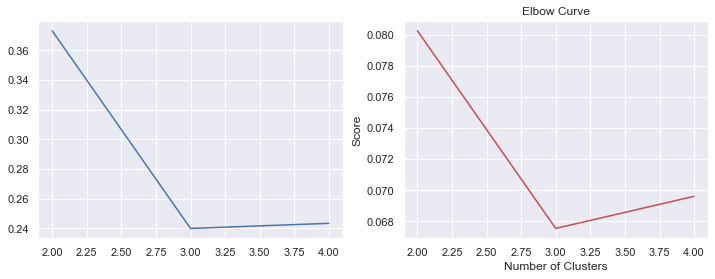

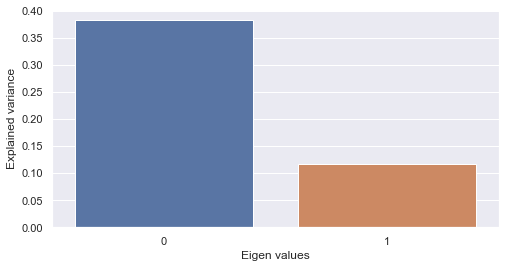

PCA on single-modal explained variance ratio: 0.4989728180660874


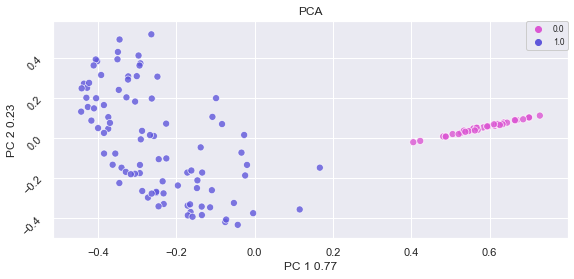

2 clusters -  silhoutte score: 0.37325199657341085 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.2400075560319417 - mutual information: 0.06753590720958419
4 clusters -  silhoutte score: 0.23682700946047697 - mutual information: 0.05883229829232589


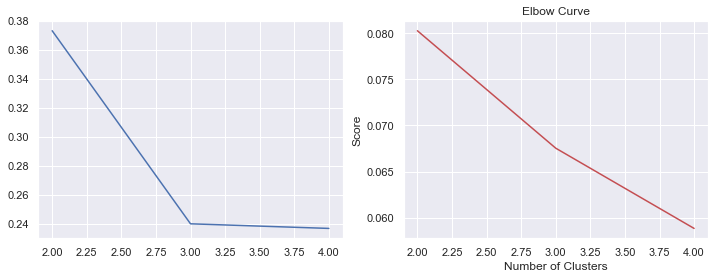

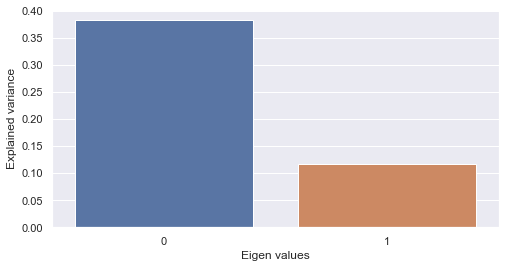

PCA on single-modal explained variance ratio: 0.4989728180660874


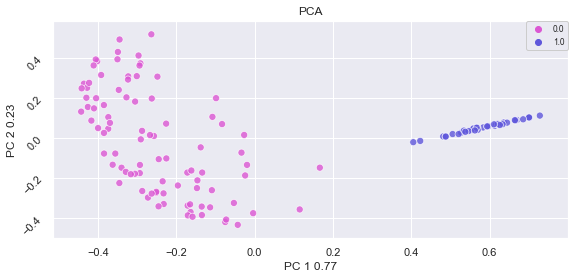

2 clusters -  silhoutte score: 0.37325199657341085 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.22590043970267054 - mutual information: 0.06174399694017896
4 clusters -  silhoutte score: 0.23113665223092372 - mutual information: 0.06317886973927686


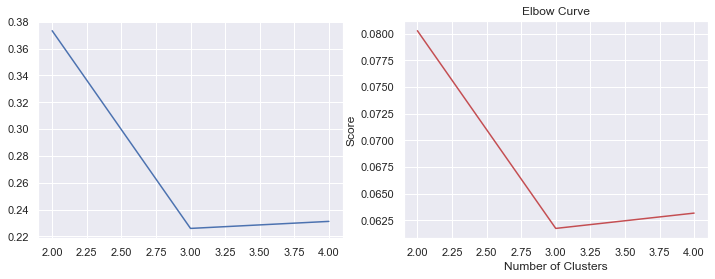

,LR accuracy,SVM accuracy,RF accuracy,LR ROC-AUC,SVM ROC-AUC,RF ROC-AUC,KMeans Silhouette,Spectral Silhouette,Hierarchical Silhouette,KMeans MI,Spectral MI,Hierarchical MI
original,0.696970,0.727273,0.636364,0.609023,0.669173,0.654135,0.725908,0.241787,0.725908,0.080276,0.010999,0.080276
PCA,0.696970,0.727273,0.575758,0.609023,0.609023,0.390977,0.730810,0.245449,0.730810,0.080276,0.010999,0.080276
KPCA,0.727273,0.727273,0.606061,0.631579,0.631579,0.556391,0.373252,0.373252,0.373252,0.080276,0.080276,0.080276


No classifier: 0.5757575757575758


In [10]:
### CLASSIFICATION ###
classify = Models.classify_with_cv(X_latent_kpca, X_latent_kpca_test, np.ravel(y_train), np.ravel(y_test), model_type="KPCA")
### CLUSTERING ###
clustering = Models.cluster(X_latent_kpca,np.ravel(y_train), model_type="KPCA")

kpca_scores = pd.DataFrame([classify + clustering], index=['KPCA'],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    
display(pd.concat([original_scores, pca_scores, kpca_scores]))
print(f"No classifier: {y_test.iloc[:,0].value_counts()[0]/len(y_test)}")

Except for Random Forest, we get the same accuracy as if we classified all samples with the same label. Clustering is similar, or worse, we get lower silohouette scores (The flattened right cluster could be the cause for this). To try to improve this situation, we could use other valid kernel functions and tune its hyperparameters. We decided to leave this out of the scope of this report, as we tried several values of most common kernel functions.

Next, we are going to find a latent space representation using the Autoencoder deep learning architecture. For a single layer input, we defined a model that has the following structure:

1. Input layer: 3575 units.
2. Dense layer: 400 units.
3. Dense bottleneck layer: encoding dimension = 100 units.
4. Dropout layer: 30% dropout rate.
5. Batch Normalization layer.
6. Dense layer: 400 units.
7. Dense output layer: 3575 units.

Layers 1 to 3 are part of the encoder, while layers 3 to 7 form the decoder. [Insertar grafico de arquitectura y/o plot de keras]


Again, we tuned the dropout, l1 regularization, l2 regularization hyperparameters by performing a grid search. [Insertar graficos de hyperparameter tuning?] . The found hyperparameter values then were dropout=0.5, l1=0.000001, l2=0.000005. Let's fit the model and encode the dataset to get the latent representation.

Compression: 35.75

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00047: early stopping


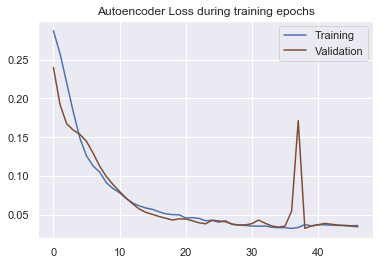

In [11]:
## Build and Train Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_train_first_norm,
                                                              X_train_first_norm,
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.000005,0.000005),
                                                              dropout=0.5,
                                                              epochs=200,
                                                              )

keras.utils.plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Encode datasets
X_latent_ae = Models.encode_dataset(X_train_first_norm, encoder)
X_latent_test_ae = Models.encode_dataset(X_test_first_norm, encoder)

We can get a visualization of the obtained latent space by performing PCA

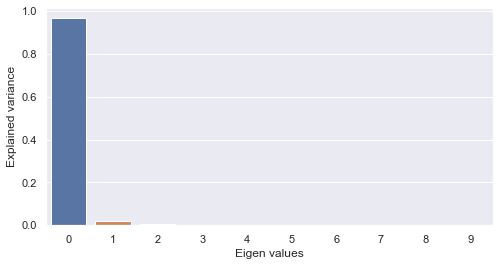

PCA on single-modal explained variance ratio: 0.9997770190238953


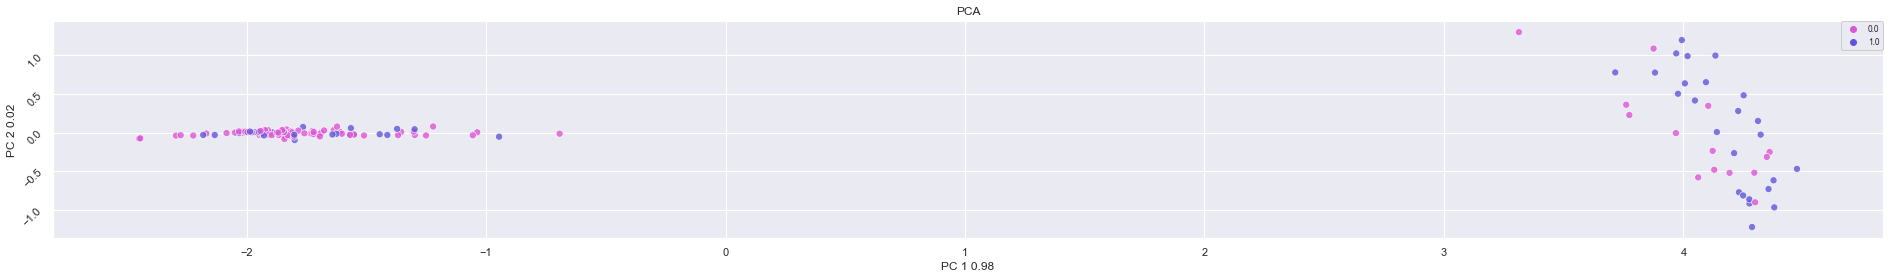

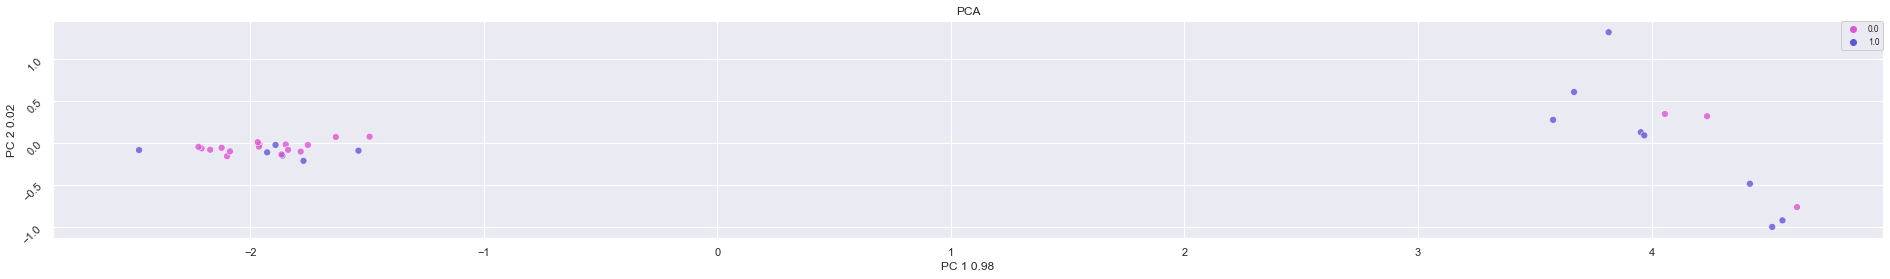

____


In [16]:
Models.perform_PCA(X_latent_ae, y_train, X_latent_test_ae, y_test)
print("____")

We have almost all variance explained by the first component, making it very difficult to visualize on scaled axis. Let´s try evaluating the latent space.

Results for AE: 

Best score for training data: 0.7 

Best C: 0.005 



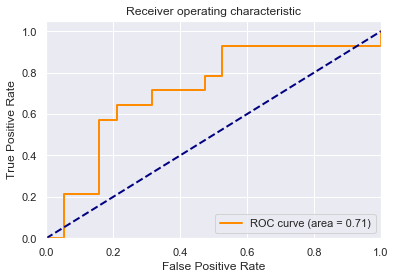

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for Logistic Regression: 0.684615
Testing  set score for Logistic Regression: 0.727273
Best score for training data: 0.6846153846153846 

Best C: 0.1 

Best Gamma: 0.05 



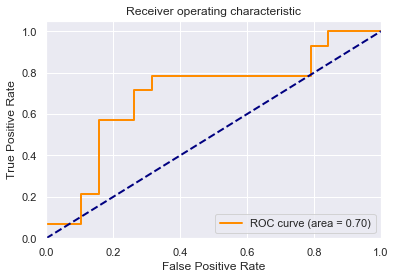

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for SVM: 0.684615
Testing  set score for SVM: 0.727273
Best score for training data: 0.6461538461538462 

Best #estimators: 80 

Best max depth: 8 



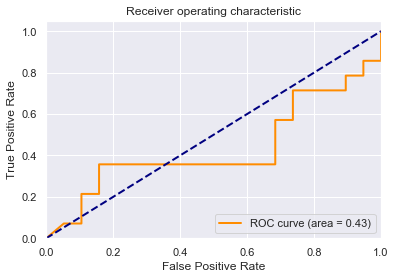

[[13  6]
 [ 9  5]]


              precision    recall  f1-score   support

           0       0.59      0.68      0.63        19
           1       0.45      0.36      0.40        14

    accuracy                           0.55        33
   macro avg       0.52      0.52      0.52        33
weighted avg       0.53      0.55      0.53        33

Training set score for RFC: 0.992308
Testing  set score for RFC: 0.545455


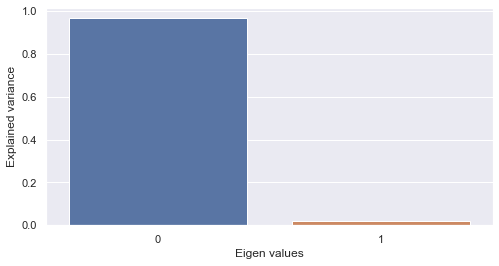

PCA on single-modal explained variance ratio: 0.9862228631973267


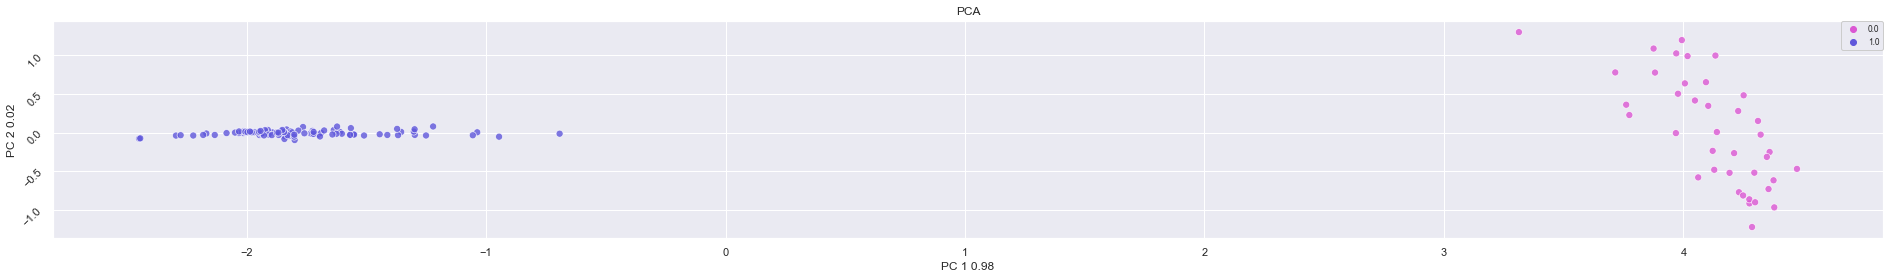

2 clusters -  silhoutte score: 0.8861761689186096 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.7796887755393982 - mutual information: 0.07229817317387624
4 clusters -  silhoutte score: 0.5105602741241455 - mutual information: 0.059383133505471884


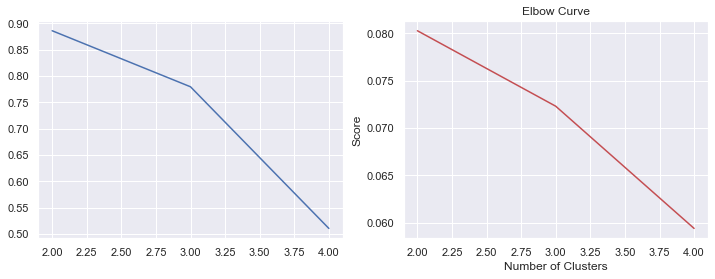

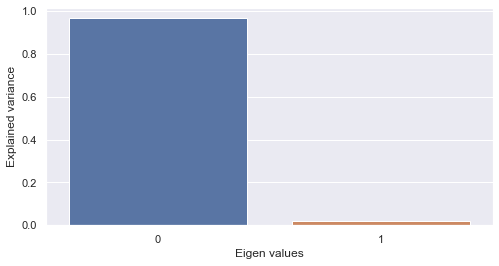

PCA on single-modal explained variance ratio: 0.9862228631973267


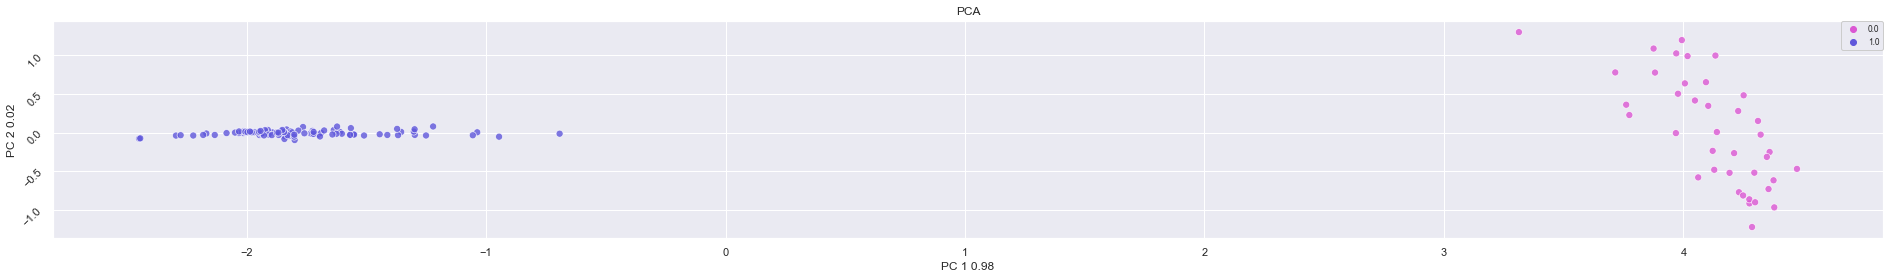

2 clusters -  silhoutte score: 0.8861761689186096 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.7788568735122681 - mutual information: 0.07207373199668257
4 clusters -  silhoutte score: 0.5269893407821655 - mutual information: 0.060030772887345416


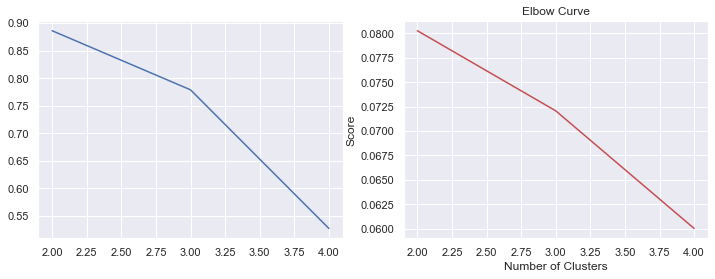

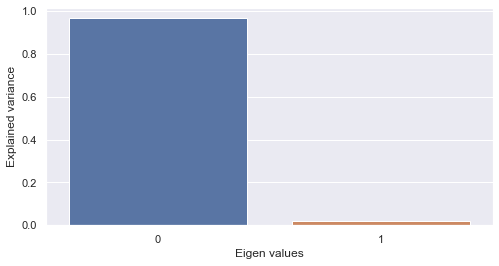

PCA on single-modal explained variance ratio: 0.9862228631973267


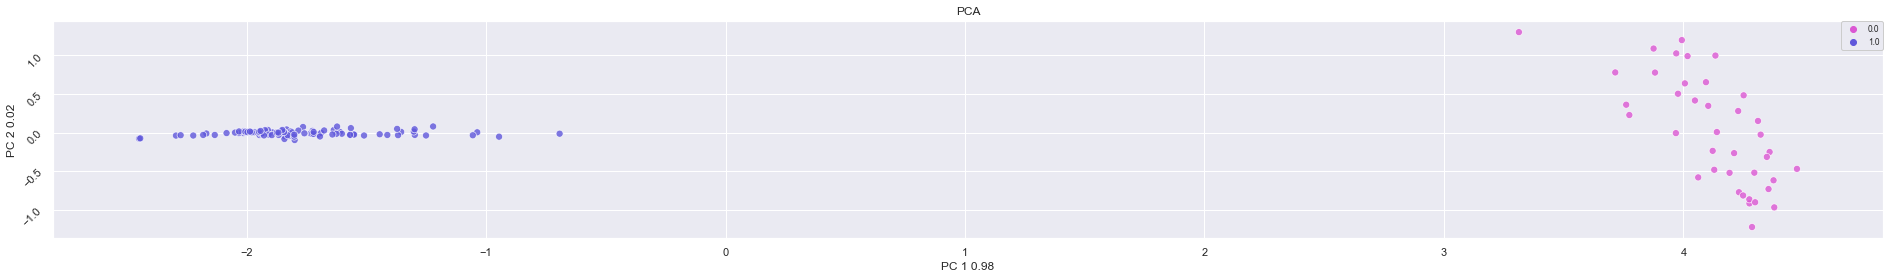

2 clusters -  silhoutte score: 0.8861761689186096 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.7748084664344788 - mutual information: 0.07679603906401791
4 clusters -  silhoutte score: 0.5233752727508545 - mutual information: 0.06512700585756888


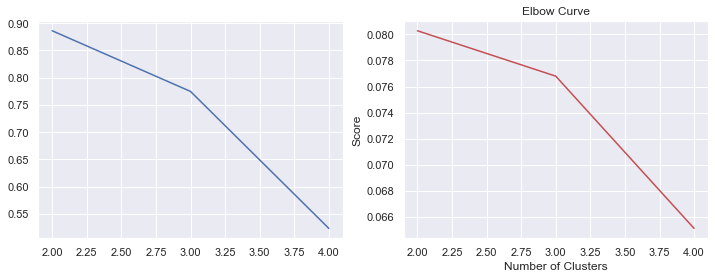

,LR accuracy,SVM accuracy,RF accuracy,LR ROC-AUC,SVM ROC-AUC,RF ROC-AUC,KMeans Silhouette,Spectral Silhouette,Hierarchical Silhouette,KMeans MI,Spectral MI,Hierarchical MI
original,0.696970,0.727273,0.636364,0.609023,0.669173,0.654135,0.725908,0.241787,0.725908,0.080276,0.010999,0.080276
PCA,0.696970,0.727273,0.575758,0.609023,0.609023,0.390977,0.730810,0.245449,0.730810,0.080276,0.010999,0.080276
KPCA,0.727273,0.727273,0.606061,0.631579,0.631579,0.556391,0.373252,0.373252,0.373252,0.080276,0.080276,0.080276
AE,0.727273,0.727273,0.545455,0.714286,0.695489,0.434211,0.886176,0.886176,0.886176,0.080276,0.080276,0.080276


No classifier: 0.5757575757575758


In [12]:
### CLASSIFICATION ###
classify = Models.classify_with_cv(X_latent_ae, X_latent_test_ae, np.ravel(y_train), np.ravel(y_test), model_type="AE")
### CLUSTERING ###
clustering = Models.cluster(X_latent_ae,np.ravel(y_train), model_type="AE")

ae_scores = pd.DataFrame([classify + clustering], index=['AE'],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    
display(pd.concat([original_scores, pca_scores, kpca_scores, ae_scores]))
print(f"No classifier: {y_test.iloc[:,0].value_counts()[0]/len(y_test)}")

Again, we do not see any significant difference for classification, and just a greater divergence of Silhouette and Mutual information. 

Finally, we are going to train the autoencoder model, with the noisy dataset that we prepared. This dataset consists of samples with swapped feature values. We used a 15% swapping rate, meaning that for each feature, we swapped 15% of samples (20 rows) with a value from another one. When we train the autoencoder with this noisy dataset as input while using the original data for reconstruction, it will try to learn to denoise it. This could lead to a latent space that better captures the structure of the dataset. 

Like for the regular AE, we tuned the dropout, l1 regularization, l2 regularization hyperparameters by performing a grid search. The found hyperparameter values then were dropout=0.4, l1=0.0000005, l2=0.0000005. Let's fit the model and encode the dataset to get the latent representation.

Let´s obtain the DAE latent space. 

Compression: 35.75

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00066: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00071: early stopping


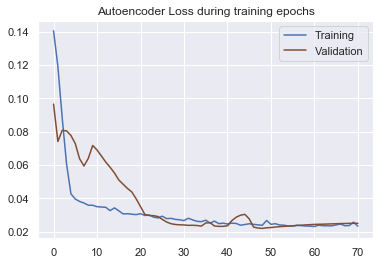

In [13]:
 ## Build and Train Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_swapped_first_norm,
                                                              X_train_first_norm,
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.0000005,0.0000005),
                                                              dropout=0.4,
                                                              epochs=200,
                                                              )

keras.utils.plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Encode datasets
X_latent_dae = Models.encode_dataset(X_train_first_norm, encoder)
X_latent_test_dae = Models.encode_dataset(X_test_first_norm, encoder)

And visualize it with PCA

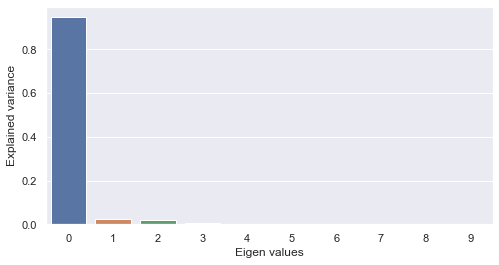

PCA on single-modal explained variance ratio: 0.999647855758667


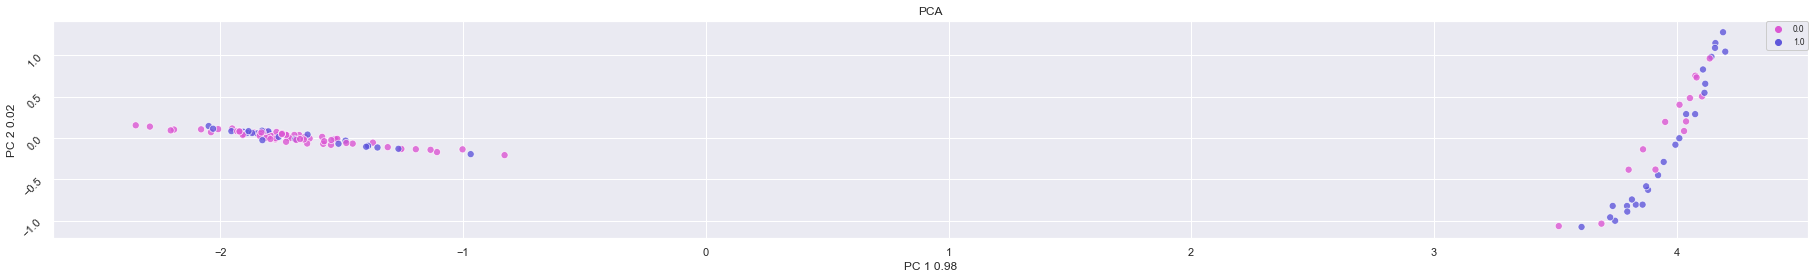

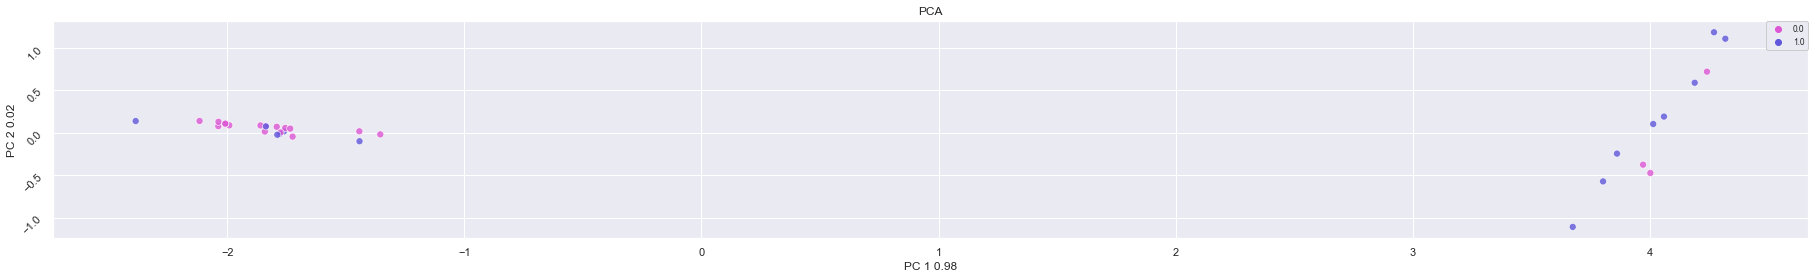

____


In [14]:
Models.perform_PCA(X_latent_dae, y_train, X_latent_test_dae, y_test)
print("____")

The variance is concentrated in the first component, so again it is not possible to visualize it. Let´s evaluate the DAE latent space.

Results for DAE: 

Best score for training data: 0.6846153846153846 

Best C: 0.01 



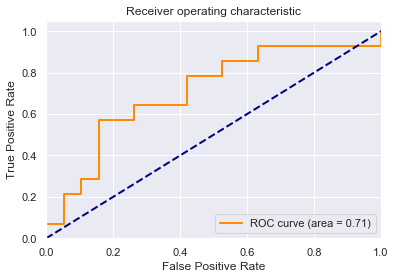

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for Logistic Regression: 0.684615
Testing  set score for Logistic Regression: 0.727273
Best score for training data: 0.6846153846153846 

Best C: 0.5 

Best Gamma: 0.01 



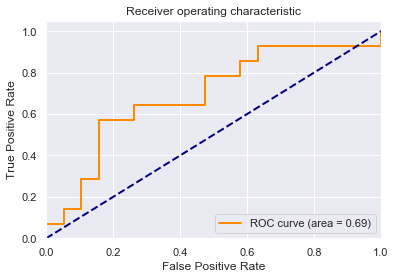

[[16  3]
 [ 6  8]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.73      0.57      0.64        14

    accuracy                           0.73        33
   macro avg       0.73      0.71      0.71        33
weighted avg       0.73      0.73      0.72        33

Training set score for SVM: 0.684615
Testing  set score for SVM: 0.727273
Best score for training data: 0.6692307692307692 

Best #estimators: 80 

Best max depth: 8 



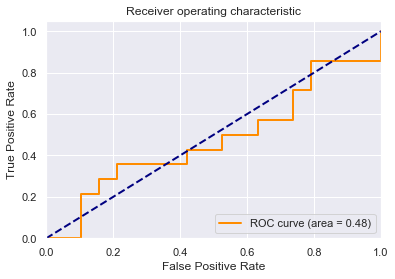

[[12  7]
 [ 9  5]]


              precision    recall  f1-score   support

           0       0.57      0.63      0.60        19
           1       0.42      0.36      0.38        14

    accuracy                           0.52        33
   macro avg       0.49      0.49      0.49        33
weighted avg       0.51      0.52      0.51        33

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.515152


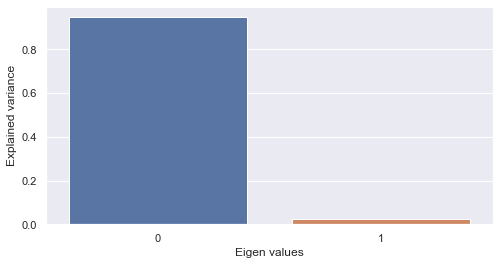

PCA on single-modal explained variance ratio: 0.9698470234870911


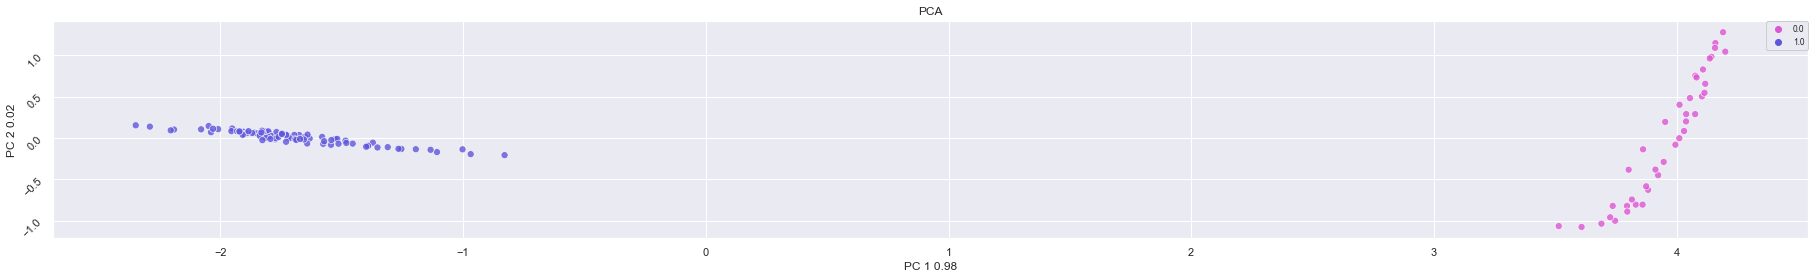

2 clusters -  silhoutte score: 0.8538699150085449 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.7637835144996643 - mutual information: 0.07679603906401791
4 clusters -  silhoutte score: 0.4080294668674469 - mutual information: 0.0610662202273985


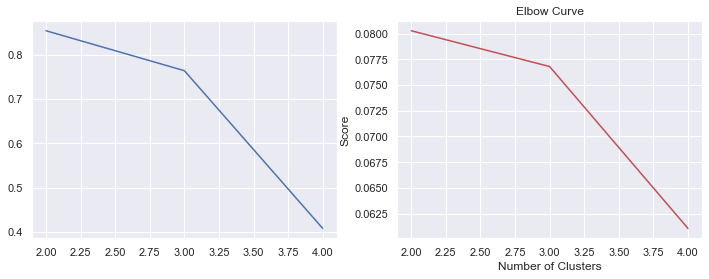

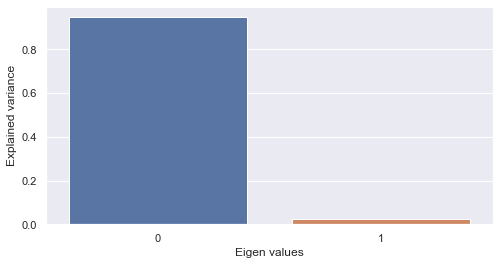

PCA on single-modal explained variance ratio: 0.9698470234870911


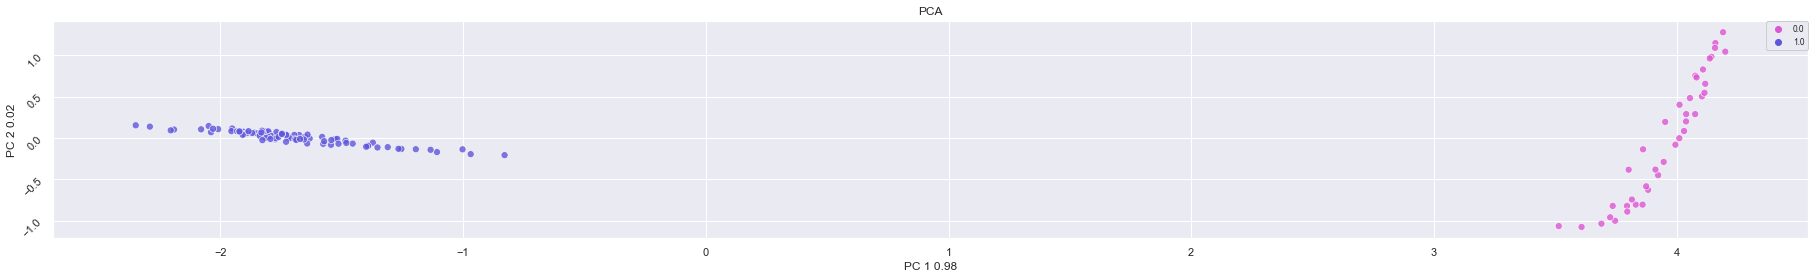

2 clusters -  silhoutte score: 0.8538699150085449 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.7638357281684875 - mutual information: 0.08012676320308663
4 clusters -  silhoutte score: 0.4088256359100342 - mutual information: 0.06501671930321613


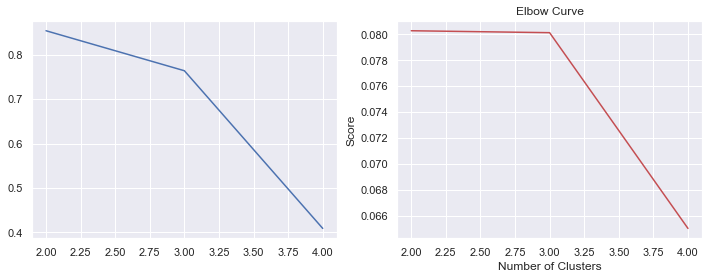

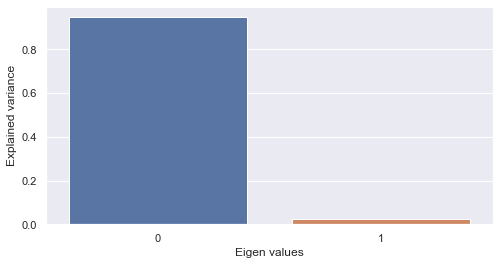

PCA on single-modal explained variance ratio: 0.9698470234870911


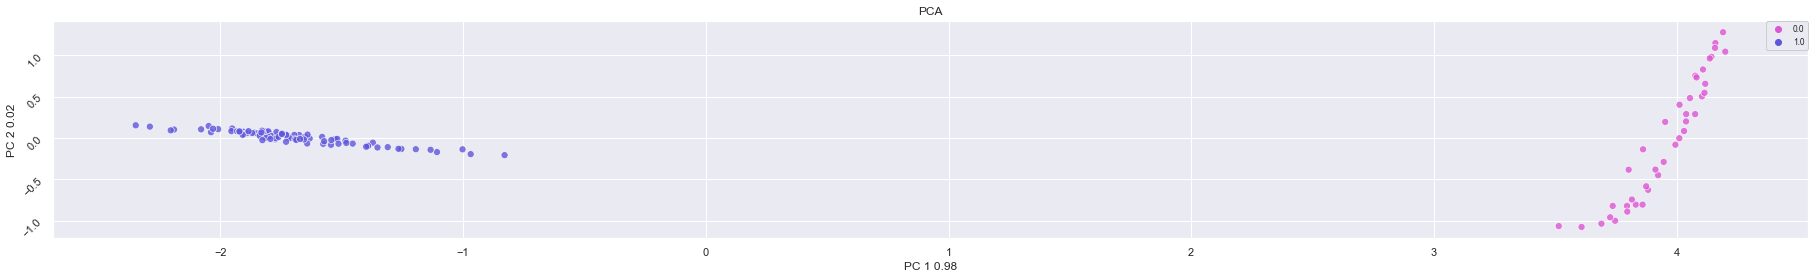

2 clusters -  silhoutte score: 0.8538699150085449 - mutual information: 0.08027624683129161
3 clusters -  silhoutte score: 0.7637835144996643 - mutual information: 0.07679603906401791
4 clusters -  silhoutte score: 0.4084656834602356 - mutual information: 0.06250341190832616


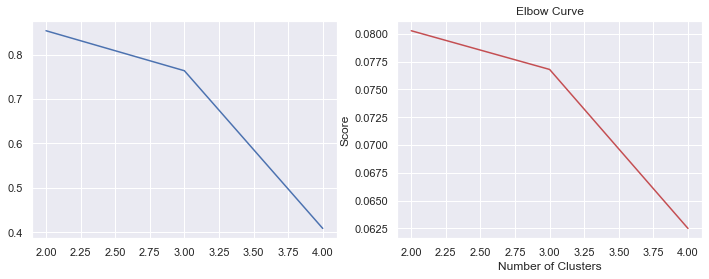

,LR accuracy,SVM accuracy,RF accuracy,LR ROC-AUC,SVM ROC-AUC,RF ROC-AUC,KMeans Silhouette,Spectral Silhouette,Hierarchical Silhouette,KMeans MI,Spectral MI,Hierarchical MI
original,0.696970,0.727273,0.636364,0.609023,0.669173,0.654135,0.725908,0.241787,0.725908,0.080276,0.010999,0.080276
PCA,0.696970,0.727273,0.575758,0.609023,0.609023,0.390977,0.730810,0.245449,0.730810,0.080276,0.010999,0.080276
KPCA,0.727273,0.727273,0.606061,0.631579,0.631579,0.556391,0.373252,0.373252,0.373252,0.080276,0.080276,0.080276
AE,0.727273,0.727273,0.545455,0.714286,0.695489,0.434211,0.886176,0.886176,0.886176,0.080276,0.080276,0.080276
DAE,0.727273,0.727273,0.515152,0.706767,0.691729,0.477444,0.853870,0.853870,0.853870,0.080276,0.080276,0.080276


No classifier: 0.5757575757575758


In [15]:
### CLASSIFICATION ###
classify = Models.classify_with_cv(X_latent_dae, X_latent_test_dae, np.ravel(y_train), np.ravel(y_test), model_type="DAE")
### CLUSTERING ###
clustering = Models.cluster(X_latent_dae,np.ravel(y_train), model_type="DAE")

dae_scores = pd.DataFrame([classify + clustering], index=['DAE'],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    
display(pd.concat([original_scores, pca_scores, kpca_scores, ae_scores, dae_scores]))
print(f"No classifier: {y_test.iloc[:,0].value_counts()[0]/len(y_test)}")

We observe the same results, and greater divergence on clustering. Denoising does not improve quality of the latent space.

### Conclusion
For the methylation dataset, the overall best solution is given when we work directly on the original dataset, but by applying PCA we can reduce the dimensionality of the dataset about 35 times with approximately the same performance. The only advantage here would be computation savings allowing us to build more complex classification models.  